# M1 ML - Science des données - Projet


# Author :

    * Pather Stevenson
    * Bilon Audrey

# 1- Librairies

In [370]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn; seaborn.set()

# 2 - Data pre-processing

## 2.1 - Récupération des données

In [371]:
emotion = pd.read_csv("CK+/emotion.csv",sep=";")
classes = pd.read_csv("CK+/classes.csv",sep=",")

In [372]:
folder = os.listdir('CK+/')
folder.remove("emotion.csv")
folder.remove("classes.csv")

## 2.2 - Génération des dataframes à partir des données

In [373]:
def generate_columns_dict(n):
    """
    
    generate a dictionnary with key:value {i: x_i, i+1 : y_i} for i from 1 to (n*2)+1
    with a step of 2 in order to assign the x and y coordinate number to dataframe
    
    :param n: the last point number of data (68 in our project)
    :type n: int
    
    :return: the dict generated
    :rtype: dict
    """
    d = {}
    j = 1
    for i in range(1,(n*2)+1,2):
        d[i] = f"x{j}"
        d[i+1] = f"y{j}"
        j += 1
    return d

In [374]:
def generate_dataframe(folder,selection,only_apex=False,center=False,mid_pt=27):
    """
    :param folder: list of subject folder directory
    :param selection: the selected subject session
    :param only_apex: True to indicate if we only keep the apex image (the last image of each session), otherwise False
    :param center: True to indicate that we want to center (x,y) coordinates
                   compared with the 28th points of neutral image of each sessions, otherwise False
    
    :type folder: List
    :type selection: pandas.DataFrame
    :type only_apex: Bool
    :type center: Bool
    
    :return: a final dataframe from data
    :rtype: pandas.DataFrame
    """
    df = pd.DataFrame()
    
    x_index = [x for x in range(1,137,2)]
    y_index = [y for y in range(2,137,2)]
    
    for f in folder:
        
        omlands = pd.read_csv(f'CK+/{f}/omlands.csv',sep=";",header=None).iloc[:,:-1].rename(columns={0: "file"})
        
        if center:
            x_neutral, y_neutral = omlands.iloc[0][1:].values.reshape(68,2)[mid_pt]
            omlands.iloc[:,x_index] = omlands.iloc[:,x_index].apply(lambda x : x_neutral - x)
            omlands.iloc[:,y_index] = omlands.iloc[:,y_index].apply(lambda y : y_neutral - y)
        if only_apex:
            index = omlands.groupby("file").apply(lambda s : s.last_valid_index()).values
            omlands = omlands.iloc[index]
        else:
            omlands = omlands.iloc[1:]
            
        df = pd.concat([df,omlands.assign(subject=f'{f}')])
        
    df = df.rename(columns={0: "file"})
    df = df.rename(columns=generate_columns_dict(68))
    df = pd.merge(selection,df,on=["subject","file"])
    
    return df

In [375]:
def plt_face(coord,title,reverse=False):
    """
    :param coord: nd.array of a coordinates point that represent faces
    :param reverse:
    :type coord: ndarray
    :type reverse: bool
    """
    figure, axis = plt.subplots(1, len(coord),figsize=(20,5))
    
    for i in range(len(coord)):
        
        axis[i].scatter(coord[i].reshape(68,2)[:,0],coord[i].reshape(68,2)[:,1])
        
        if reverse: 
            axis[i].invert_yaxis()
            plt.xlim([0,1100])
            plt.ylim([950,300])
            
    figure.suptitle(title,fontsize=15)

**Description des dataframes générés :**
$\newline$
* *df_all* contient les données non centrées des images les moins expressives au plus expressives (image apex incluse) par expression et par session,
* *df_apex* contient les données non centrées des images apex uniquement par expression et par session,
* *df_all_center* contient les données centrées des images les moins expressives au plus expressives (image apex incluse) par expression et par session,
* *df_apex_center* contient les données centrées des images apex par expression et par session
$\newline$

**Remarque :**
$\newline$
* Dans tous les cas, la première image de chaque session, qui est une image d'expression neutre, est retirée des données pour ne pas biaiser l'entraînement de nos modèles.
* Le centrage des données est effectué effectuant la soustraction des coordonnées de chaque image de session avec le point $(x28,y28)$ de l'image neutre de la session respective. Dans le cas du dataframes où l'on ne considére que les images apex (df_apex_center) c'est alors la considération du déplacement des points entre l'image neutre et l'image apex uniquement.

In [376]:
df_all = generate_dataframe(folder,emotion,only_apex=False,center=False)
df_apex = generate_dataframe(folder,emotion,only_apex=True,center=False)
df_all_center = generate_dataframe(folder,emotion,only_apex=False,center=True)
df_apex_center = generate_dataframe(folder,emotion,only_apex=True,center=True)

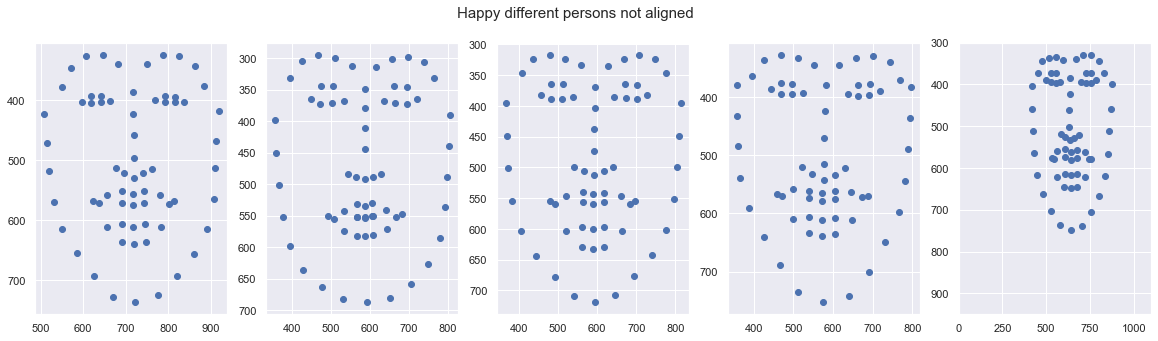

In [377]:
coord = df_apex[df_apex['emotion']==1].loc[:,'x1':].values
plt_face(coord[[np.random.randint(0,len(coord)) for i in range(5)]],"Happy different persons not aligned",reverse=True)

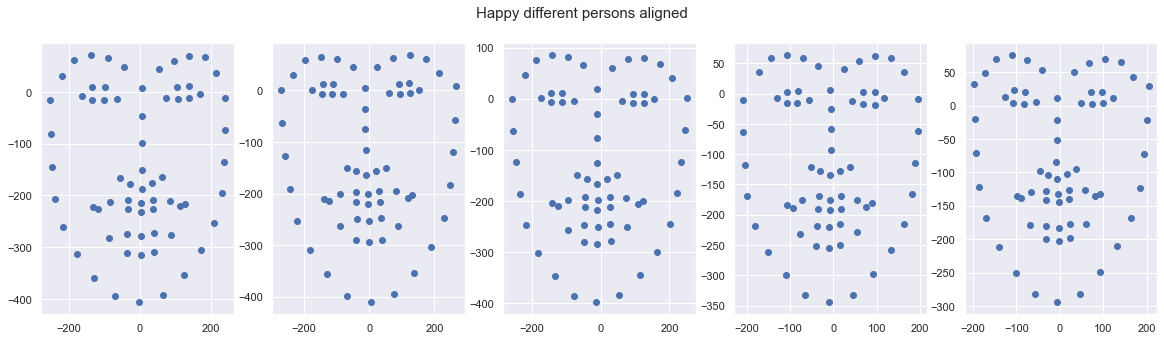

In [378]:
coord_center = df_apex_center[df_apex_center['emotion']==1].loc[:,'x1':].values[:5]
plt_face(coord_center,"Happy different persons aligned")

* Nous pouvons constater que le centrage des images est bien correct

## 2.3 - Contrôle et analyse des données

In [379]:
df_all.nunique(axis=0)

subject     99
file         9
emotion      6
x1         276
y1         237
          ... 
y66        303
x67        289
y67        314
x68        289
y68        301
Length: 139, dtype: int64

In [380]:
df_all.describe()

,file,emotion,x1,y1,x2,y2,x3,y3,x4,y4,...,x64,y64,x65,y65,x66,y66,x67,y67,x68,y68
count,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,...,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000
mean,3.344479,3.094479,404.496626,413.397393,408.776534,471.491258,417.323466,528.953528,427.886196,586.402914,...,655.070552,609.886503,704.276994,618.362117,655.104448,625.304601,630.745092,628.535276,607.463037,625.229908
std,1.929669,1.808173,59.838803,46.630814,59.397958,45.717950,58.943436,45.417490,58.846098,45.765850,...,55.369289,49.379733,56.522082,49.903948,55.207500,53.606944,55.417428,53.994994,56.054571,53.579797
min,1.000000,1.000000,256.000000,290.000000,264.000000,355.000000,274.000000,411.000000,287.000000,465.000000,...,516.000000,468.000000,547.000000,476.000000,517.000000,476.000000,504.000000,477.000000,486.000000,476.000000
25%,2.000000,1.000000,365.000000,383.000000,370.000000,441.000000,378.000000,497.000000,388.000000,553.000000,...,619.000000,575.000000,668.000000,584.000000,619.000000,589.000000,595.000000,592.000000,571.000000,588.000000
50%,3.000000,3.000000,396.000000,412.000000,401.000000,471.000000,407.000000,528.000000,418.000000,584.000000,...,646.000000,607.000000,695.000000,614.000000,646.000000,618.000000,621.000000,622.000000,599.000000,619.000000
75%,5.000000,5.000000,437.000000,452.000000,439.000000,507.000000,445.000000,564.000000,455.000000,621.000000,...,684.000000,649.000000,733.000000,654.000000,685.000000,666.000000,660.000000,670.000000,638.000000,666.000000
max,9.000000,6.000000,637.000000,543.000000,640.000000,594.000000,645.000000,643.000000,657.000000,702.000000,...,846.000000,724.000000,906.000000,748.000000,846.000000,810.000000,820.000000,814.000000,800.000000,806.000000


In [381]:
df_all_center.describe()

,file,emotion,x1,y1,x2,y2,x3,y3,x4,y4,...,x64,y64,x65,y65,x66,y66,x67,y67,x68,y68
count,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,...,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000,6520.000000
mean,3.344479,3.094479,226.323313,-15.535890,222.043405,-73.629755,213.496472,-131.092025,202.933742,-188.541411,...,-24.250613,-212.025000,-73.457055,-220.500613,-24.284509,-227.443098,0.074847,-230.673773,23.356902,-227.368405
std,1.929669,1.808173,24.996918,20.999805,24.479151,20.564044,23.889285,21.466923,23.384451,23.602231,...,11.374319,25.517719,18.099773,28.891517,11.806977,33.580328,10.475030,34.023478,11.158362,33.536044
min,1.000000,1.000000,118.000000,-121.000000,122.000000,-153.000000,126.000000,-200.000000,124.000000,-263.000000,...,-77.000000,-298.000000,-142.000000,-331.000000,-79.000000,-383.000000,-45.000000,-388.000000,-22.000000,-380.000000
25%,2.000000,1.000000,210.000000,-29.000000,206.000000,-86.000000,197.000000,-144.000000,186.000000,-204.000000,...,-30.000000,-229.000000,-83.000000,-241.000000,-31.000000,-245.000000,-6.000000,-248.000000,17.000000,-244.000000
50%,3.000000,3.000000,227.000000,-15.000000,224.000000,-73.000000,215.000000,-130.000000,205.000000,-188.000000,...,-24.000000,-213.000000,-71.000000,-220.000000,-24.000000,-225.000000,0.000000,-229.000000,23.000000,-225.500000
75%,5.000000,5.000000,243.000000,-2.000000,239.000000,-59.750000,230.000000,-117.000000,219.000000,-173.000000,...,-18.000000,-195.000000,-62.000000,-200.000000,-18.000000,-206.000000,5.000000,-209.000000,29.000000,-206.000000
max,9.000000,6.000000,322.000000,46.000000,322.000000,-13.000000,314.000000,-66.000000,297.000000,-115.000000,...,44.000000,-135.000000,1.000000,-138.000000,45.000000,-156.000000,62.000000,-158.000000,80.000000,-157.000000


* Le centrage des données permet de réduire l'écart entre les données. On peut observer cette normalisation de nos points au travers des moyennes de chaque x et y mais également avec les valeurs min max et l'écart type.

In [382]:
emotion.isnull().sum().sum(), df_all.isnull().sum().sum(), df_apex.isnull().sum().sum()

(0, 0, 0)

In [383]:
df_all_center.isnull().sum().sum(), df_apex_center.isnull().sum().sum()

(0, 0)

* Ici nous pouvons observer qu'aucune valeur NULL n'est présente dans nos dataframes générés directement à partir des données et également après modification pour le centrage de celles-ci.

In [384]:
def plt_reprensetation(df,df_name,classes_label=classes):
    """
    show the represensation of each given classes label given for each given dataframe in df
    
    :param df: list of dataframe to analyse
    :param df_name: name in order of each dataframe in df 
    :param classes_label: the dataframe of corresponding label of classes value (default value the classes dataframe created from "CK+/classes.csv"
    
    :type df: pandas.Dataframe
    :type df_name: List
    :type classes_label: pandas.Dataframe
    
    :sideeffect: print graph with matplotlib lib
    
    :return: Nothing
    :rtype: None
    """
    for i in range(len(df)):
        d = df[i]
        label = df_name[i]
        
        fig , ax = plt.subplots(figsize=(12,5))
        
        sns.countplot(x='emotion', data=d, order = d['emotion'].value_counts(ascending=False).index)

        name = classes['emotion'].values[d['emotion'].value_counts().index-1]
        pourcent = d['emotion'].value_counts(ascending=False, normalize=True).values * 100

        ax.bar_label(container=ax.containers[0],labels=[f'{p[0]} ({p[1]:.2f}%)' for p in zip(name, pourcent)])

        plt.title(f"Représentation des émotions dans {label}",fontsize=20)
        plt.show()

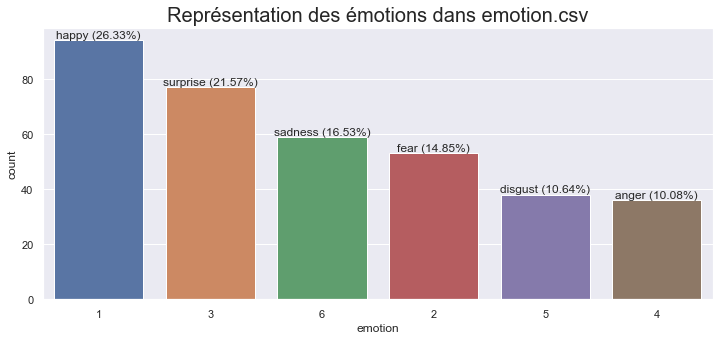

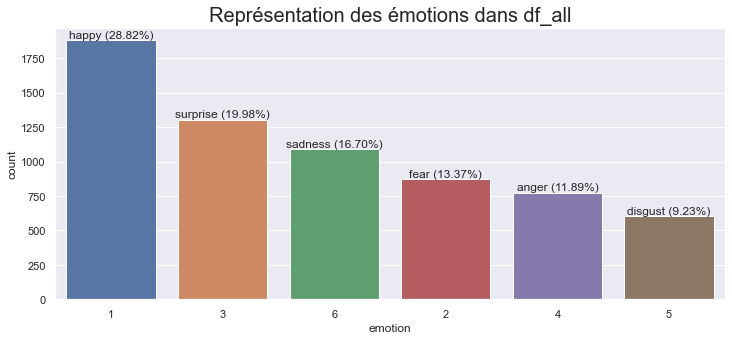

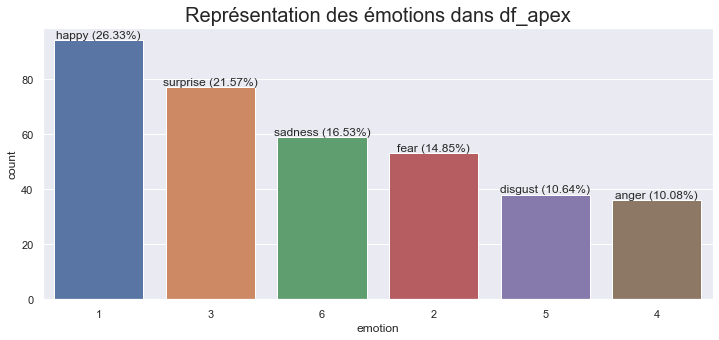

In [385]:
plt_reprensetation([emotion,df_all,df_apex],['emotion.csv','df_all','df_apex'])

In [386]:
df_all

,subject,file,emotion,x1,y1,x2,y2,x3,y3,x4,...,x64,y64,x65,y65,x66,y66,x67,y67,x68,y68
0,S005,1,5,430,400,429,478,439,555,457,...,778,669,829,676,776,672,746,676,717,672
1,S005,1,5,428,398,426,478,435,557,452,...,779,668,829,675,778,672,746,676,717,673
2,S005,1,5,431,400,430,477,439,555,456,...,779,667,829,675,778,670,747,675,718,671
3,S005,1,5,429,399,430,477,441,555,459,...,778,665,828,672,777,669,746,674,717,669
4,S005,1,5,431,393,431,469,439,544,457,...,779,662,830,670,778,667,746,671,716,667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6515,S138,6,1,399,405,402,463,410,519,421,...,648,587,715,581,648,586,621,590,595,587
6516,S138,6,1,398,405,401,461,408,518,419,...,648,587,712,580,647,585,621,589,595,586
6517,S138,6,1,397,402,398,459,405,515,416,...,649,586,714,579,648,585,620,589,593,585
6518,S138,6,1,398,403,400,460,407,516,417,...,650,586,719,577,650,584,620,588,592,585


* A l'aide de ces graphique nous pouvons constater la représentation de chaque émotion de la sélection des données demandée dans le fichier *CK+/emotion.csv*.

* Les expressions happy et surprise sont dominantes dans nos images de visage. Les autres émotions ont au plus 6% de représentation de différence dans les données.

* Pour le dataframe *df_all* les représentations sont à $\pm 1\%$ les mêmes que pour le dataframe *emotion*, on peut noter tout de même une augmentation de 2% de la présence de l'expression happy

* Les représentation des dataframe *emotion* et *df_apex* sont égales car étant donner que *df_apex* ne contient qu'une seule image par expression par session alors ont obtient le même nombre d'occurrence pour la colonne "emotion" des deux dataframes.

* Ainsi on peut noter également que les dataframes contenant que les images apex possédent 357 images de par la sélection des sessions demandés dans emotion.csv alors que dans les dataframes où toutes les images sont considérés nous avons 6520 images.

In [387]:
def get_correlation_drop(df,seuil,show=False,palette=False):
    """
    """
    cor_matrix = df.loc[:,'x1':].corr(method='pearson')
    p = None
    
    if palette: 
        p = sns.diverging_palette(1, 1, as_cmap=True)
    if show:
        sns.heatmap(cor_matrix,cmap=p)
    
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
    
    return [col for col in upper_tri.columns if any(upper_tri[col] > seuil)]

Cette fonction va nous permettre de retirer de nos dataframes les attributs qui ont un seuil de corrélation supérieur à un seuil donné en argument pour pouvoir comparer notre modèle et conclure sur la pertinance de retirer ces attributs. 

## 2.4 - Préparation des données pour l'apprentissage

In [388]:
X_all, y_all = df_all.loc[:,'x1':].values, df_all['emotion'].values

In [389]:
X_all_center, y_all_center = df_all_center.loc[:,'x1':].values, df_all_center['emotion'].values

In [390]:
X_apex, y_apex = df_apex.loc[:,'x1':].values, df_apex['emotion'].values

In [391]:
X_apex_center, y_apex_center = df_apex_center.loc[:,'x1':].values, df_apex_center['emotion'].values

In [392]:
data = [(X_all,y_all,'df_all'), (X_all_center,y_all_center,'df_all_center'),(X_apex,y_apex,'df_apex'), (X_apex_center,y_apex_center,'df_apex_center')]

# 3 - Première approche

## 3.0 - import sklearn

In [393]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [394]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

## 3.1 - Recherche d'un modèle

### Remarque : Dans un premier temps, nous souhaitons trouver un modèle qui permet d'obtenir des résultats satisfaisant sans centrage des données ou optimisation des hyperparamètres.

In [395]:
models = [RandomForestClassifier(), SVC(), DecisionTreeClassifier(), 
          SGDClassifier(), KNeighborsClassifier(), GaussianNB(), 
          LogisticRegression(n_jobs=-1), MLPClassifier(max_iter=1000), DummyClassifier(strategy="most_frequent")]

In [396]:
colors = {'RandomForestClassifier': 'peru','SVC': 'brown', 'GaussianNB': 'blue', 
          'DecisionTreeClassifier':'orange', 'SGDClassifier':'green','KNeighborsClassifier':'red',
          'LogisticRegression':'purple', 'MLPClassifier' : 'lightcoral', 'DummyClassifier' :'magenta'}

Ainsi nous allons sélectionner un modèle parmis ceux-ci :

* RandomForestClassifier
* SVC
* DecisionTreeClassifier
* SGDClassifier
* LogisticRegression
* KNeighborsClassifier
* GaussianNB
* MLPClassifier

En se basant sur leur score en cross-validation, puis en fonction de leur temps d'apprentissage et de prédiction en fonction de la taille de l'échantillon donné.

La présence d'un DummyClassifier avec pour stratégie la classe la plus fréquente a pour but de permettre une comparaison avec un modèle dit naïve de par sa stratégie de prédiction pour venir justifier ou non la nécessisté d'un modèle plus robuste.

In [397]:
def cv_score_multiple_sizes(estimators,X_train,y_train,sizes):
    """"""    
    cv = {m.__class__.__name__ : [] for m in models}
    rng = np.arange(len(X_train))
    
    for s in sizes:
        index = np.random.choice(rng,s)
        for m in estimators:
            cv[m.__class__.__name__] += [cross_val_score(m,X_train[index],y_train[index])]
    
    return cv

In [398]:
def plt_cv_scores(cv,sizes,title,colors):
    """"""
    fig, ax = plt.subplots(figsize=(5,5))

    for m in cv:
        ax.plot(sizes,[np.median(i) for i in cv[m]],label=f'{m}',color=colors[m])
        ax.fill_between(sizes,[min(i) for i in cv[m]],[max(i) for i in cv[m]],alpha=0.2,color=colors[m])
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Taille')
    plt.ylabel('Précision')

* Sur toutes les images (df_all et df_all_center) :

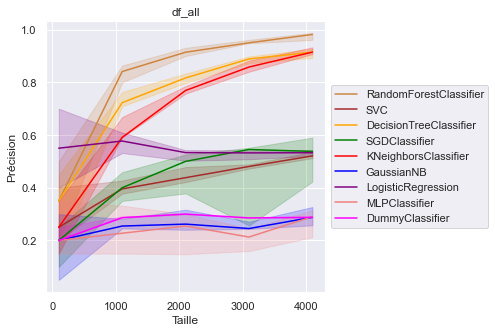

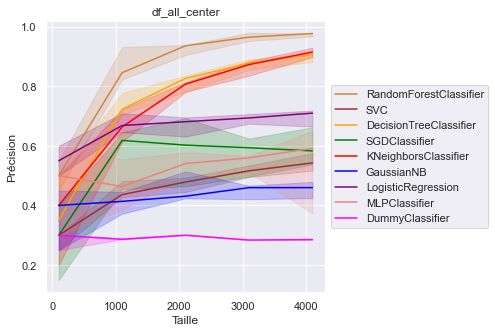

In [399]:
for X,y,label in data[:2]:
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.33)
    sizes = list(range(100,len(X_train),1000))
    cv = cv_score_multiple_sizes(models,X_train,y_train,sizes)
    plt_cv_scores(cv,sizes,label,colors)

* On peut ainsi observer que pour certains modèles la variation de la taille de l'échantillon permet d'obtenir de bons résultats sur la moyenne des scores de cross-validation
* Un certains nombreux de classifier sont proches du classifier DummyClassifier qui utilise une prédiction naïve par la classe la plus fréquente
* Les modèles qui ressortent sont RandomForestClasifier, DecisionTreeClassifier et KNeighborsClassifier
* Le meilleur classifier en se basant sur ce graphique est le RandomForestClassifier qui pour une taille d'échantillon presque maximale obtient une précision proche de $1$

* Sur les images apex (df_apex et df_apex_center) :

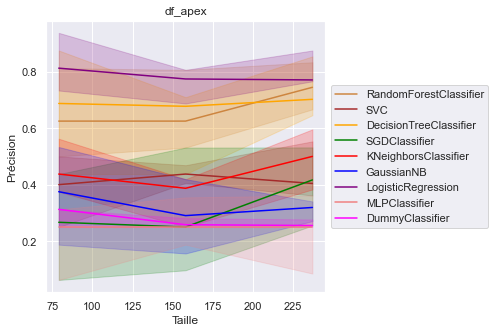

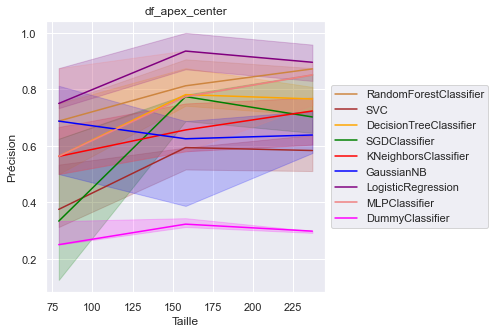

In [400]:
for X,y,label in data[2:]:
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.33)
    n = len(X_train)
    sizes = list(range(int(n/3),n,int(n/3)))
    cv = cv_score_multiple_sizes(models,X_train,y_train,sizes)
    plt_cv_scores(cv,sizes,label,colors)

* On peut constater ici que dans le cas où l'on considère uniquement les images apex nous obtenons des précisions inférieur que les meilleurs modèles du graphique ou l'on considére toutes les images,
* Néanmoins on peut constater que DecisionTree et RandomForest sont retrouvent encore une fois ici dans les meilleurs choix, bien que précisement dans le cas des images apex le meilleur modèle est LogisticRegression, mais dans les graphiques précédent nous avons que celui-ci avec toutes les images n'obtient pas de bons résultats.

Ainsi nous faisons le choix de sélectionner 3 modèles suivants pour la suite de notre démarche qui ressortent des deux observations effectuer précédemment :

* RandomForestClassifier
* DecisionTreeClassifier
* KNeighborsClassifier


In [401]:
models_selection = [RandomForestClassifier(), DecisionTreeClassifier(), KNeighborsClassifier()]

Mesurons maintenant le temps d'apprentissage et de prédiction de notre sélection : 

In [402]:
def get_fit_pred_time(models,X_train,y_train,sizes):
    """"""
    t_fit, t_predict = {m.__class__.__name__ : [] for m in models}, {m.__class__.__name__ : [] for m in models}
    rng = np.arange(len(X_train))
    
    for s in sizes:
        index = np.random.choice(rng,s)
        for m in models:
            
            r = %timeit -o -q -r1 -n1 m.fit(X_train[index],y_train[index])
            t_fit[m.__class__.__name__] += [r.timings]
        
            r = %timeit -o -q -r1 -n1 m.predict(X_train[index])
            t_predict[m.__class__.__name__] += [r.timings]
    
    return t_fit, t_predict

In [403]:
def plt_fit_pred_time(time_fit,time_predict,colors):
    fig, axis = plt.subplots(1,2,figsize=(15,5))

    for m in t_fit:
        axis[0].plot(sizes,t_fit[m],label=f'{m}',color=colors[m])
        axis[1].plot(sizes,t_predict[m],label=f'{m}',color=colors[m])
    
    for ax in axis:
        ax.legend()
        ax.set_xlabel("Taille échantillon")
        ax.set_ylabel("Temps (s)")

    axis[0].set_title("Temps d'apprentissage en fonction de la taille")
    axis[1].set_title("Temps de prédiction en fonction de la taille")

* Pour la pertinence de notre observation, nous allons nous concentrer ici uniquement sur le dataframe df_all qui comporte un volume de données bien plus conséquent que df_apex qui ne contient que les images apex.

In [404]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,random_state=0,test_size=0.33)

In [405]:
t_fit, t_predict = get_fit_pred_time(models_selection,X_train,y_train,sizes)

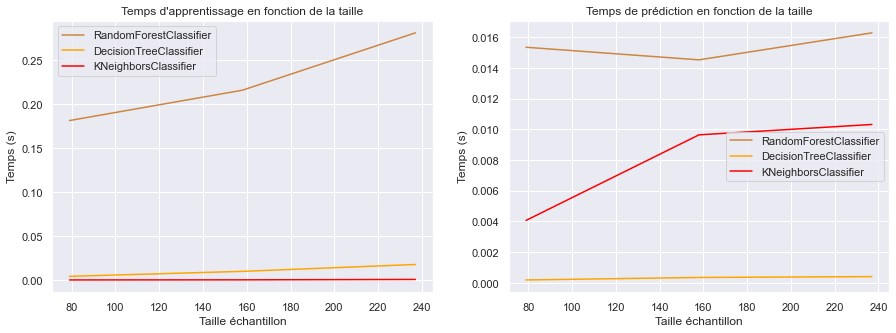

In [406]:
plt_fit_pred_time(t_fit,t_predict,colors)

**On peut constater que :**
* Le RandomForest a un temps d'apprentissage qui risque d'augmenter très rapidement avec la taille de l'échantillon, mais se comporte bien en temps de prédiction,
* Le KNeighbors montre lui un temps d'apprentissage très rapide et constant en fonction de la taille, mais demande un temps en prédiction qui peut augmente fortement avec la taille de l'échantillon
* Le DecisionTree montre un temps en apprentissage qui se comporte acceptable avec la taille de l'échantillon et n'évolue que très peu en temps de prédiction en restant étant très rapide.

**Conclusion :**
* le modèle DecisionTreeClassifier permet d'obtenir un bon score tout en étant un très bon compromis en temps d'apprentissage et de prédiction comparer aux deux autres meilleurs modèles.

## 3.1 - Hyper-parameters tuning

Remarque : Maintenant que nous pu sélectionner un modèle, nous pouvons effectuer une recherche des hyperparamètres par une recherche par grille dans le but d'améliorer notre modèle de prédiction

In [407]:
param_dt = {'max_depth' : np.arange(1,15), 'criterion' : ['gini', 'entropy'],
         'splitter' : ['best', 'random'], 'min_samples_split' : [2,5,10]}

clf = DecisionTreeClassifier()

In [408]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,random_state=0,test_size=0.33)

In [409]:
gs = GridSearchCV(estimator=clf, param_grid = param_dt, n_jobs=-1).fit(X_train,y_train)

In [410]:
best_param = gs.best_params_
best_param

{'criterion': 'entropy',
 'max_depth': 14,
 'min_samples_split': 2,
 'splitter': 'best'}

In [411]:
gs.score(X_test,y_test)

0.879182156133829

Ainsi après une recherche des hyperparamètres nous obtenons un score en généralisation de 0.884.

Voyons si nous ne pouvons pas améliorer encore ce score à l'aide d'un boosting par AdaBoost :

In [412]:
param_ada = {"base_estimator__criterion" : ["gini", "entropy"],
         "base_estimator__splitter" :   ["best", "random"],
         'base_estimator__min_samples_split' : [2,5,10],
         'base_estimator__max_depth' : np.arange(1,15),
         "n_estimators": [1, 2]}

In [413]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
gs = GridSearchCV(estimator=clf, param_grid = param_ada, n_jobs=-1).fit(X_train,y_train)

In [414]:
gs.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 14,
 'base_estimator__min_samples_split': 10,
 'base_estimator__splitter': 'random',
 'n_estimators': 2}

In [415]:
gs.score(X_test,y_test)

0.8907992565055762

Nous pouvons constater une amélioration du score en généralisation d'au plus 0.03, ce qui ne justifie pas le coup en temps ajouter par un boosting par AdaBoost dans notre cas.

Maintenant que nous avons obtenus les hyperparamètres pour notre modèle, nous pouvons visualiser l'arbre de décision obtenu :

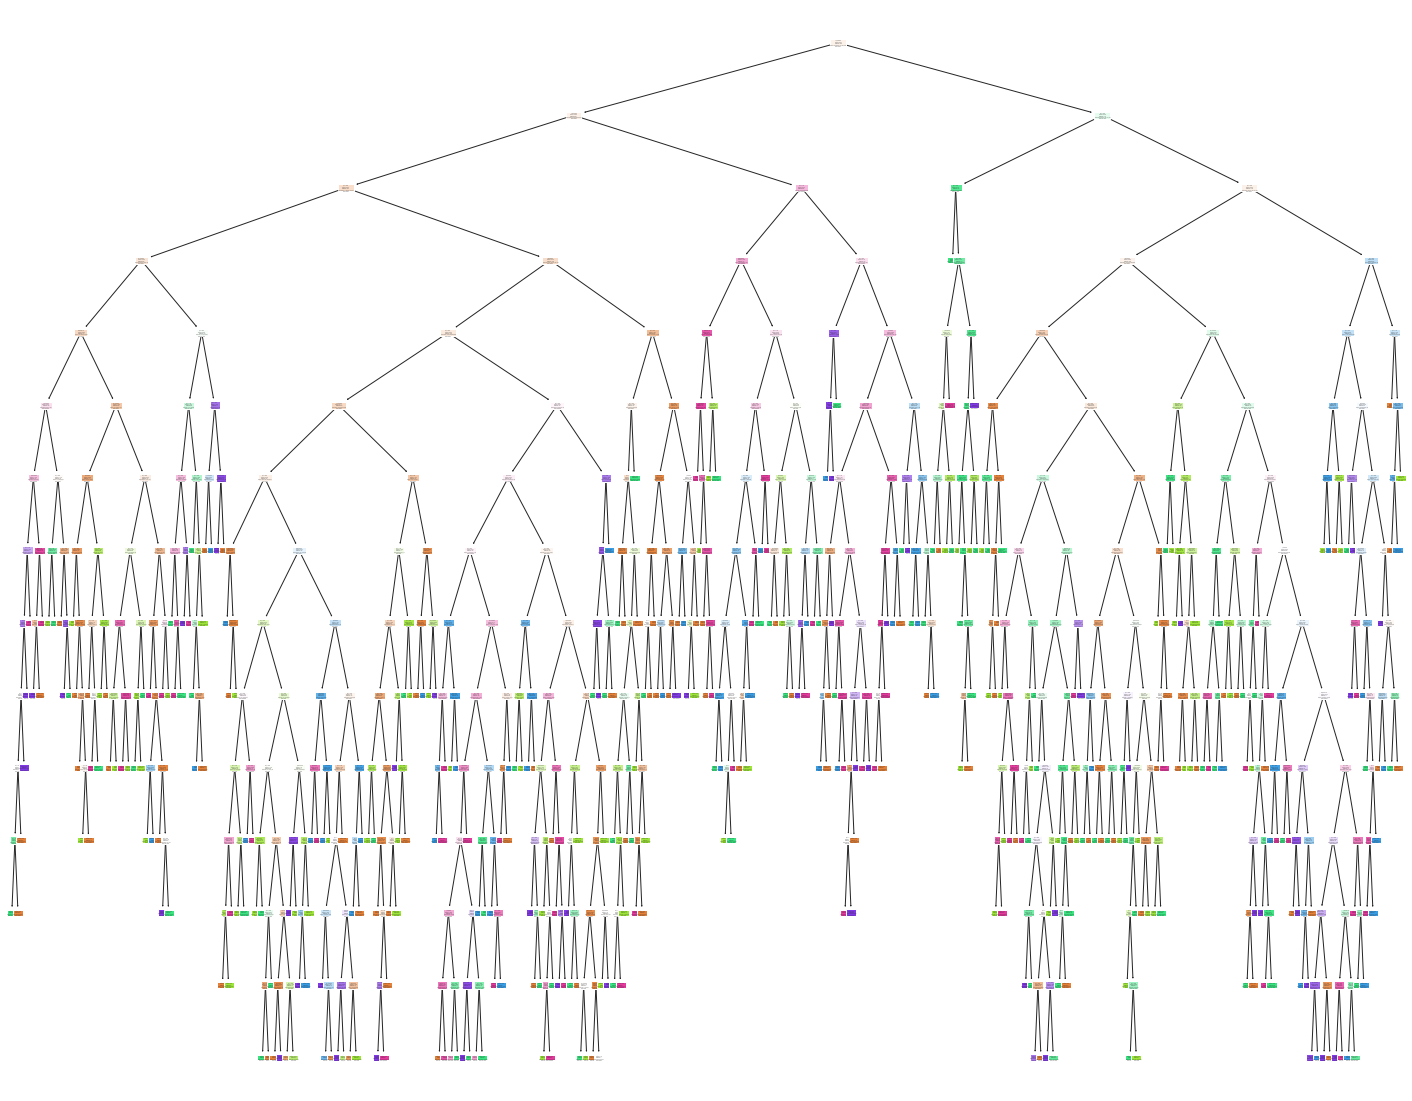

In [416]:
clf = DecisionTreeClassifier(**best_param)

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf.fit(X_train,y_train), feature_names=np.arange(1,137),
                   class_names=classes['emotion'],
                   filled=True)

In [417]:
print(export_text(clf))

|--- feature_113 <= 667.50
|   |--- feature_109 <= 612.50
|   |   |--- feature_31 <= 422.50
|   |   |   |--- feature_120 <= 563.50
|   |   |   |   |--- feature_108 <= 681.50
|   |   |   |   |   |--- feature_115 <= 607.50
|   |   |   |   |   |   |--- feature_129 <= 560.50
|   |   |   |   |   |   |   |--- feature_48 <= 714.00
|   |   |   |   |   |   |   |   |--- feature_36 <= 426.50
|   |   |   |   |   |   |   |   |   |--- feature_19 <= 694.00
|   |   |   |   |   |   |   |   |   |   |--- feature_44 <= 625.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_44 >  625.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- feature_19 >  694.00
|   |   |   |   |   |   |   |   |   |   |--- class: 5
|   |   |   |   |   |   |   |   |--- feature_36 >  426.50
|   |   |   |   |   |   |   |   |   |--- class: 5
|   |   |   |   |   |   |   |--- feature_48 >  714.00
|   |   |

## 3.2 - Comparaison avec centrage et image apex

In [418]:
clf = DecisionTreeClassifier()

for X,y,label in data:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)
    
    gs = GridSearchCV(estimator=clf, param_grid = param_dt,n_jobs=-1).fit(X_train,y_train)
    
    print(f'{label} : {gs.score(X_test,y_test)}')

df_all : 0.8787174721189591
df_all_center : 0.8480483271375465
df_apex : 0.4152542372881356
df_apex_center : 0.4406779661016949


In [419]:
len(X_all), len(X_apex)

(6520, 357)

* On peut constater que le centrage par rapport à l'image neutre dans le cas où l'on prend en compte toutes les images ou dans le cas où l'on ne prend que l'image apex ne permet d'obtenir un meilleur score que les données où l'on prend toutes les images (moins expressive à la plus expressive, image neutre excluse et image apex incluse) sans centrage.


* En effet, cela peut s'expliquer par le fait que si l'on ne considére que l'image apex alors le découpage décisionnel fait par notre modèle sur les attributs peuvent s'avérer moins fins, en ce sens que l'information apporté par les images les moins expressives jusqu'au image apex incluse permet d'enrichir le modèle et permet d'être plus précis sur les prédictions.


* En plus de cela, on peut expliquer aussi plus basiquement que notre modèle avec est entraîné sur beaucoup plus de données dans le cas où l'on prend toutes les images soit 6520 en tout contre seulement 357 si l'on ne considére que les images apex. Ainsi le modèle étant moins fourni en données est underfit et obtient un score beaucoup satisfaisant.

## 3.3 - Exclusion des attributs fortement corrélés

Nous allons essayer de mettre en évidence ou non la nécessisté de conserver les attributs fortement corrélés dans nos données pour observer si leur supression modifie fortement la qualité de notre modèle.

In [420]:
def search_best_seuil(model,param,df,seuil=[0.95,0.96,0.97,0.98,0.99,0.999],verbose=False):
    """"""
    X,y = df.loc[:,'x1':].values, df['emotion'].values
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)
    nb_attr = X.shape[1]
    all_attr = GridSearchCV(estimator=model, param_grid = param,n_jobs=-1).fit(X_train,y_train).score(X_test,y_test)
    
    res = []
    attr = []
    
    for i in range(len(seuil)):
        df_drop = df.drop(columns=get_correlation_drop(df,seuil=seuil[i] ))
        len_attr = len(df_drop.columns[3:])
        attr += [len_attr]
        
        X,y = df_drop.loc[:,'x1':].values, df_drop['emotion'].values
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)
        
        seuil_score = GridSearchCV(estimator=model, param_grid = param,n_jobs=-1).fit(X_train,y_train).score(X_test,y_test)
        res += [seuil_score]
        if verbose: print(f'seuil : {seuil[i]}, score : {seuil_score}, with {len_attr} attr')
        
    if verbose: print(f'seuil : None, score : {all_attr}, with  {nb_attr} attr')
    res += [all_attr]
    attr += [nb_attr]
    return attr, res

In [421]:
seuil_df_all = search_best_seuil(DecisionTreeClassifier(),param_dt,df_all,verbose=True)

seuil : 0.95, score : 0.6919144981412639, with 3 attr
seuil : 0.96, score : 0.8355018587360595, with 4 attr
seuil : 0.97, score : 0.8327137546468402, with 5 attr
seuil : 0.98, score : 0.8694237918215614, with 8 attr
seuil : 0.99, score : 0.8736059479553904, with 10 attr
seuil : 0.999, score : 0.8350371747211895, with 94 attr
seuil : None, score : 0.8703531598513011, with  136 attr


In [422]:
seuil_df_all_center = search_best_seuil(DecisionTreeClassifier(),param_dt,df_all_center,verbose=True)

seuil : 0.95, score : 0.8805762081784386, with 29 attr
seuil : 0.96, score : 0.8671003717472119, with 36 attr
seuil : 0.97, score : 0.8671003717472119, with 44 attr
seuil : 0.98, score : 0.8801115241635687, with 56 attr
seuil : 0.99, score : 0.8824349442379182, with 90 attr
seuil : 0.999, score : 0.8768587360594795, with 133 attr
seuil : None, score : 0.8680297397769516, with  136 attr


In [423]:
seuil_df_apex = search_best_seuil(DecisionTreeClassifier(),param_dt,df_apex,verbose=True)

seuil : 0.95, score : 0.3220338983050847, with 4 attr
seuil : 0.96, score : 0.3389830508474576, with 4 attr
seuil : 0.97, score : 0.3474576271186441, with 7 attr
seuil : 0.98, score : 0.4406779661016949, with 9 attr
seuil : 0.99, score : 0.4576271186440678, with 16 attr
seuil : 0.999, score : 0.4067796610169492, with 95 attr
seuil : None, score : 0.3983050847457627, with  136 attr


In [424]:
seuil_df_apex_center = search_best_seuil(DecisionTreeClassifier(),param_dt,df_apex_center,verbose=True)

seuil : 0.95, score : 0.5508474576271186, with 26 attr
seuil : 0.96, score : 0.5338983050847458, with 35 attr
seuil : 0.97, score : 0.5677966101694916, with 43 attr
seuil : 0.98, score : 0.5169491525423728, with 60 attr
seuil : 0.99, score : 0.576271186440678, with 87 attr
seuil : 0.999, score : 0.5338983050847458, with 132 attr
seuil : None, score : 0.5932203389830508, with  136 attr


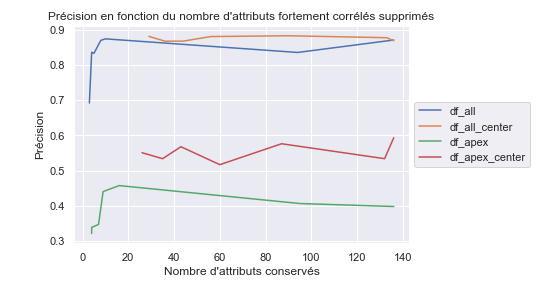

In [425]:
fig, ax = plt.subplots()

ax.plot(seuil_df_all[0],seuil_df_all[1],label='df_all')
ax.plot(seuil_df_all_center[0],seuil_df_all_center[1],label='df_all_center')
ax.plot(seuil_df_apex[0],seuil_df_apex[1],label='df_apex')
ax.plot(seuil_df_apex_center[0],seuil_df_apex_center[1],label='df_apex_center')

plt.title("Précision en fonction du nombre d'attributs fortement corrélés supprimés")
plt.xlabel("Nombre d'attributs conservés")
plt.ylabel('Précision')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
plt.show()

A l'aide du graphique ainsi obtenus et des résultats, on peut observer que dans le cas des données non centrées la conservation de tous les attributs (les 136 coordonnées) permettent d'obtenir une précision maximale, mais en revanche dans le cas des données centrées le pic de précision n'est pas pour un nombre d'attributs maximum :

* Dans le cas du dataframes centré où toutes les images sont considérés ce pic se trouve avec 90 attributs conservés avec seuil de corrélation d'exclusion > 0.99
* Dans le cas où l'on considéré uniquement les images apex centrées la meilleure précision est obtenus avec 60 attributs conservés soit avec un seuil de corrélation d'exclusion de 0.98

Conclusion :

Plus généralmeent au vu des résultats du graphique, nous pourrions utiliser les données centrées on l'on considéré toutes les images (df_all_center) avec un seuil de corrélation d'exclusion des attributs corrélés de 0.99. Nous aurions alors une capacité de prédiction quasi-égale qu'avec les données non centrées (df_all) et les 136 attributs. 

# 4 - Deuxième approche

## 4.0 - Préparation des données

Dans cette deuxième approche nous allons étudier si le fait de garantir l'équilibre entre le nombre d'instances de chaque expression, fait varier nos résultats.

In [426]:
df_all_equi = df_all.loc[df_all['emotion'].isin(classes['id'])].groupby('emotion').head(np.min(df_all['emotion'].value_counts()))

In [427]:
df_apex_equi = df_apex.loc[df_apex['emotion'].isin(classes['id'])].groupby('emotion').head(np.min(df_apex['emotion'].value_counts()))

In [428]:
df_all_equi_center = df_all_center.loc[df_all_center['emotion'].isin(classes['id'])].groupby('emotion').head(np.min(df_all_center['emotion'].value_counts()))

In [429]:
df_apex_equi_center = df_apex.loc[df_apex_center['emotion'].isin(classes['id'])].groupby('emotion').head(np.min(df_apex_center['emotion'].value_counts()))

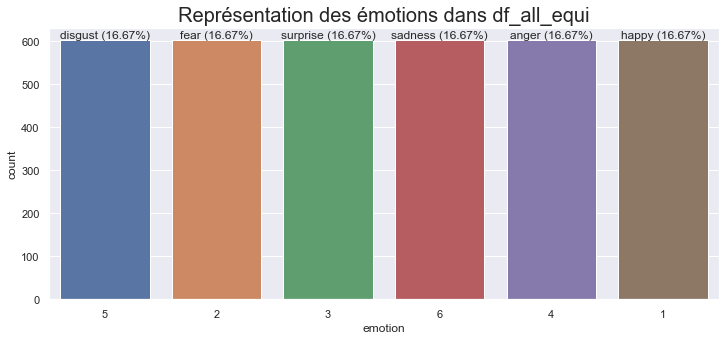

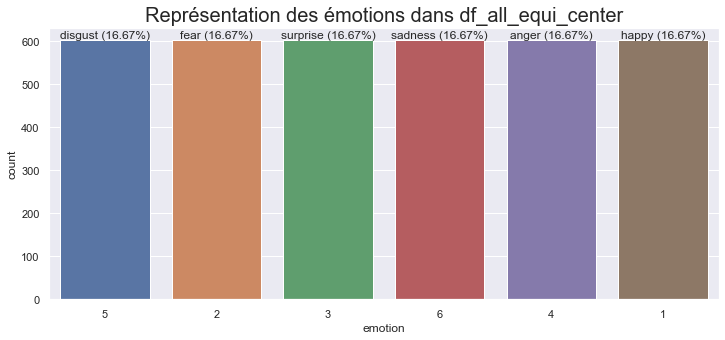

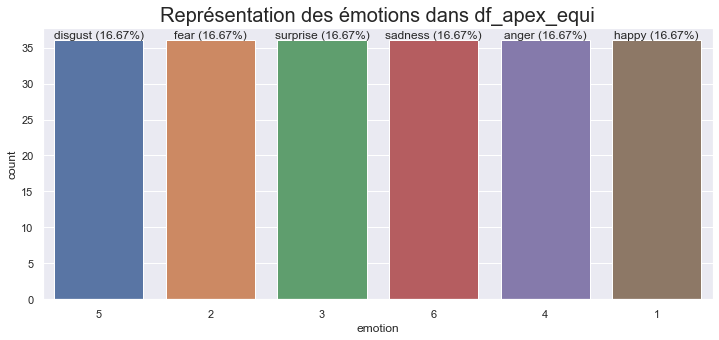

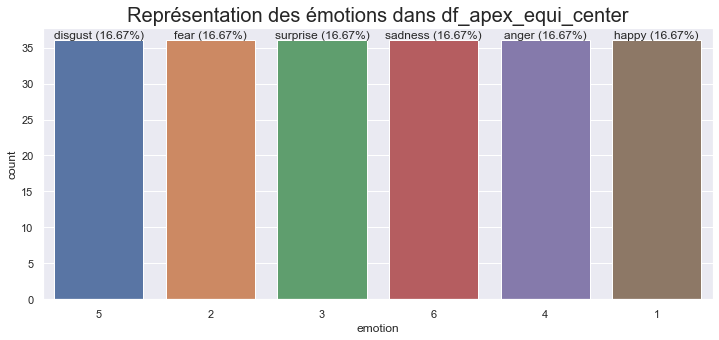

In [430]:
plt_reprensetation([df_all_equi,df_all_equi_center,df_apex_equi,df_apex_equi_center],['df_all_equi','df_all_equi_center','df_apex_equi','df_apex_equi_center'])

Ainsi on obtient effectivement des dataframes avec un équilibre entre chaque expression.

In [431]:
X_all_equi, y_all_equi = df_all_equi.loc[:,'x1':].values, df_all_equi['emotion'].values

In [432]:
X_all_equi_center, y_all_equi_center = df_all_equi_center.loc[:,'x1':].values, df_all_equi_center['emotion'].values

In [433]:
X_apex_equi, y_apex_equi = df_apex_equi.loc[:,'x1':].values, df_apex_equi['emotion'].values

In [434]:
X_apex_equi_center, y_apex_equi_center = df_apex_equi_center.loc[:,'x1':].values, df_apex_equi_center['emotion'].values

In [435]:
data_equi = [(X_all_equi, y_all_equi,'df_all_equi'),(X_all_equi_center,y_all_equi_center,'df_all_equi_center'),
             (X_apex_equi,y_apex_equi,'df_apex_equi'), (X_apex_equi_center,y_apex_equi_center,'df_apex_equi_center')]

## 4.1 - Résultats et comparaison avec centrage et image apex

In [436]:
clf = DecisionTreeClassifier()

for X,y,label in data_equi:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)
    
    gs = GridSearchCV(estimator=clf, param_grid = param_dt,n_jobs=-1).fit(X_train,y_train)
    
    print(f'{label} : {gs.score(X_test,y_test)}')

df_all_equi : 0.9077181208053692
df_all_equi_center : 0.863255033557047
df_apex_equi : 0.3472222222222222
df_apex_equi_center : 0.4027777777777778


Ainsi pour les dataframes suivants on obtient, par rapport au dataframe non équilibré : 


* pour df_all_equi et df_all_equi_center nous obtenons générélamenet une légère augmentation du score,
* pour df_apex_equi et pour df_apex_equi_center une diminution du score est observée


On peut également constater que le centrage ou la considération uniquement de la différence entre image neutre et image apex n'influence pas de manière positif le score de $0.9$ obtenus (df_all_equi) dans le cas où l'on prend toutes les images (neutre excluse, apex incluse). De même qu'en première approche, les images apex sélectionnés par les indications des sessions demandés dans emotion.csv nous font obtenir 357 images apex puis ici nous venons équilibré le nombre d'images de chaque expression. Donc nous réduisons de 357 images à 216 images, soit un nombre potentiellement insuffissant de données pour la complexité de la classification multiclasses que l'on souhaite effectuer.

Il est donc difficile de statué sur le bénéfice à ne considéré que les images apex étant donner que nous prenons donc que très peu de données et que nous sommes possiblement dans un cas d'underfitting de notre modèle en utilisant que ces données.

## 4.2- Avec exclusion des attributs fortement corrélés

Observons maintenant si dans le cas où le nombre d'instances est équilibré et où des attributs fortement corrélés ne sont pas conservés une variation de la précision est observée par rapport au dataframe non équilibré

In [437]:
seuil_df_all_equi = search_best_seuil(DecisionTreeClassifier(),param_dt,df_all_equi,verbose=True)

seuil : 0.95, score : 0.7743288590604027, with 3 attr
seuil : 0.96, score : 0.8338926174496645, with 4 attr
seuil : 0.97, score : 0.8422818791946308, with 5 attr
seuil : 0.98, score : 0.8162751677852349, with 6 attr
seuil : 0.99, score : 0.8456375838926175, with 11 attr
seuil : 0.999, score : 0.9043624161073825, with 91 attr
seuil : None, score : 0.8699664429530202, with  136 attr


In [438]:
seuil_df_all_equi_center = search_best_seuil(DecisionTreeClassifier(),param_dt,df_all_equi_center,verbose=True)

seuil : 0.95, score : 0.8842281879194631, with 32 attr
seuil : 0.96, score : 0.8733221476510067, with 41 attr
seuil : 0.97, score : 0.8901006711409396, with 45 attr
seuil : 0.98, score : 0.8691275167785235, with 56 attr
seuil : 0.99, score : 0.8859060402684564, with 85 attr
seuil : 0.999, score : 0.8926174496644296, with 132 attr
seuil : None, score : 0.8859060402684564, with  136 attr


In [439]:
seuil_df_apex_equi = search_best_seuil(DecisionTreeClassifier(),param_dt,df_apex_equi,verbose=True)

seuil : 0.95, score : 0.19444444444444445, with 3 attr
seuil : 0.96, score : 0.2222222222222222, with 4 attr
seuil : 0.97, score : 0.2222222222222222, with 7 attr
seuil : 0.98, score : 0.2916666666666667, with 9 attr
seuil : 0.99, score : 0.3472222222222222, with 14 attr
seuil : 0.999, score : 0.3194444444444444, with 95 attr
seuil : None, score : 0.4166666666666667, with  136 attr


In [440]:
seuil_df_apex_equi_center = search_best_seuil(DecisionTreeClassifier(),param_dt,df_apex_equi_center,verbose=True)

seuil : 0.95, score : 0.3055555555555556, with 3 attr
seuil : 0.96, score : 0.3055555555555556, with 4 attr
seuil : 0.97, score : 0.4027777777777778, with 7 attr
seuil : 0.98, score : 0.25, with 9 attr
seuil : 0.99, score : 0.3472222222222222, with 14 attr
seuil : 0.999, score : 0.3194444444444444, with 95 attr
seuil : None, score : 0.3611111111111111, with  136 attr


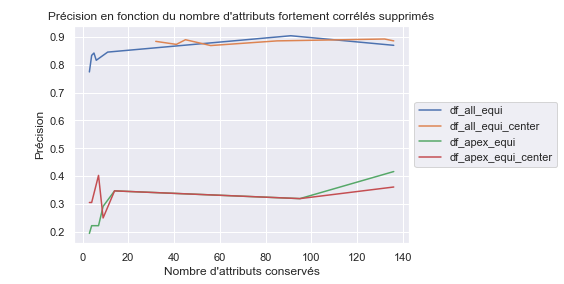

In [441]:
fig, ax = plt.subplots()

ax.plot(seuil_df_all_equi[0],seuil_df_all_equi[1],label='df_all_equi')
ax.plot(seuil_df_all_equi_center[0],seuil_df_all_equi_center[1],label='df_all_equi_center')
ax.plot(seuil_df_apex_equi[0],seuil_df_apex_equi[1],label='df_apex_equi')
ax.plot(seuil_df_apex_equi_center[0],seuil_df_apex_equi_center[1],label='df_apex_equi_center')

plt.title("Précision en fonction du nombre d'attributs fortement corrélés supprimés")
plt.xlabel("Nombre d'attributs conservés")
plt.ylabel('Précision')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
plt.show()

* Dans le cas du df_all_equi on peut observer que le pic de précision est dans le cas où aucun seuil n'est appliqué donc quand nous conservons tous les attributs,

* Dans le cas du df_all_equi_center contrairement à quand le nombre d'instances n'était pas équilibré, on peut observer que la précision stagne avec un léger creux entre 40 et 80 attributs conservés. Ainsi on observe deux pics, un avec 40 attributs et un avec un peu moins que tous les attributs, donc au seuil 0.96 et 0.999

* Pour df_apex_equi on peut observer un pic à environ 95 attributs conservés soit pour un seuil 0.999, puis une chute jusqu'au nombre maximum d'attributs conservés
* Pour le df_apex_equi_center le pic de précision est atteint pour un nombre maximum d'attributs conservés


Conclusion :

Dans le cas de données équilibré en nombre d'instances des expressions, On observe globalement une perte de précision avec l'exclusion d'attributs, sauf dans le du dataframe df_all_equi_center donc des données centrées avec toutes les images. Où l'on obtient un pic de précision avec 40 attributs conservés et un seuil d'exclusion de 0.96. Ce qui permet d'obtenir une précision plus élevé qu'avec les données non centrées pour un même nombre d'attributs et une précision très proche que si l'on prenait le nombre maximum d'attributs (centrée ou non) et équilibré ou non.

Ainsi il peut être intéressant d'utiliser le dataframe df_all_equi_center qui permet des performances très proche voir meilleure pour un volume de données moins élevé car application d'une exclusion des attributs avec un seuil de corrrélation supérieur à 0.96. 

Plus généralement, cette approche se trouve intéressante tant pour la précision que pour la réduction du volume de données à traiter pour notre modèle.

# 5 - Troisième approche

Dans cette troisième approche nous allons étudier les performances en présence d'occultations et bruitages faciaux. Dans le but de savoir jusqu'à quel point les techniques d'apprentissage proposées dans les démarches précédentes sont robustes à ces altérations et bruitages en termes d'étendue et d'intensité. 

In [442]:
def get_range_points(start,end):
    """"""
    res = []
    for i in range(start,end+1):
        res += [f'x{i}', f'y{i}']
    return np.asarray(res)

In [443]:
def add_noise(X,mu,sigma):
    """"""
    return X + np.random.normal(mu, sigma, X.shape)

In [444]:
def get_score_region(clf,df,selected_regions,noise=(0,30,False),verbose=False):
    """"""
    res = []

    for regions in selected_regions:    
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:,np.concatenate([d_regions[r] for r in regions])].values,
                                                            df['emotion'].values,test_size=0.33,random_state=0)
        if noise[-1]:
            X_train = add_noise(X_train,noise[0],noise[1])
        gs = GridSearchCV(estimator=clf, param_grid = param_dt,n_jobs=-1).fit(X_train,y_train)
        
        score = gs.score(X_test,y_test)
        res += [score]
    
        if verbose: print(f'{regions} : {score}')
        
    return np.asarray(res)

In [445]:
def plt_score_region(scores,selected_regions,labels):
    fig, aux = plt.subplots(figsize=(30,15))
    x = np.linspace(1,len(selected_regions),len(selected_regions))
    
    for i in range(len(scores)):
        plt.plot(x,scores[i],label=labels[i])
    
    plt.xticks(x,selected_regions,fontsize=10)
    plt.title("Précision en fonction d'une sélection de régions du visage")
    plt.xlabel('Régions')
    plt.ylabel('Précision')
    plt.legend(loc='best')

In [446]:
d_regions = {'left eye' : get_range_points(37,42), 'right eye' : get_range_points(43,48),
           'noise' : get_range_points(28,36), 'mouth' : get_range_points(49,68),
           'left eyebrow' : get_range_points(18,22), 'right eyebrow' : get_range_points(23,27),
           'face outline' : get_range_points(1,17)}

Nous faisons le choix de prendre les combinaisons de régions suivantes :

* Mouth
* Left eye + Right eye
* Left eye + Right eye + Mouth
* Left eyebrow + Right eyebrow
* Left eyebrow + Right eyebrow + Mouth
* Left eye + Right eye + Left eyebrow + Right eyebrow 
* Left eye + Right eye + Left eyebrow + Right eyebrow + Mouth

In [447]:
selected_regions = [['mouth'],['left eye', 'right eye'], ['left eyebrow', 'right eyebrow'],
           ['left eye', 'right eye', 'left eyebrow', 'right eyebrow', 'mouth'],
          ['left eye', 'right eye', 'left eyebrow', 'right eyebrow'],
          ['left eyebrow', 'right eyebrow', 'mouth'],
           ['left eye', 'right eye','mouth']]

**Rermarque :** les éxecutions suivantes peuvent prendre un certains temps (1 à 2 min) au vu du gridsearchCV effectuer pour chaque combinaisons de régions dans get_score_region.

In [448]:
score_regions = [get_score_region(DecisionTreeClassifier(),df,selected_regions,verbose=False)
                 for df in [df_all,df_all_center,df_apex,df_apex_center]]

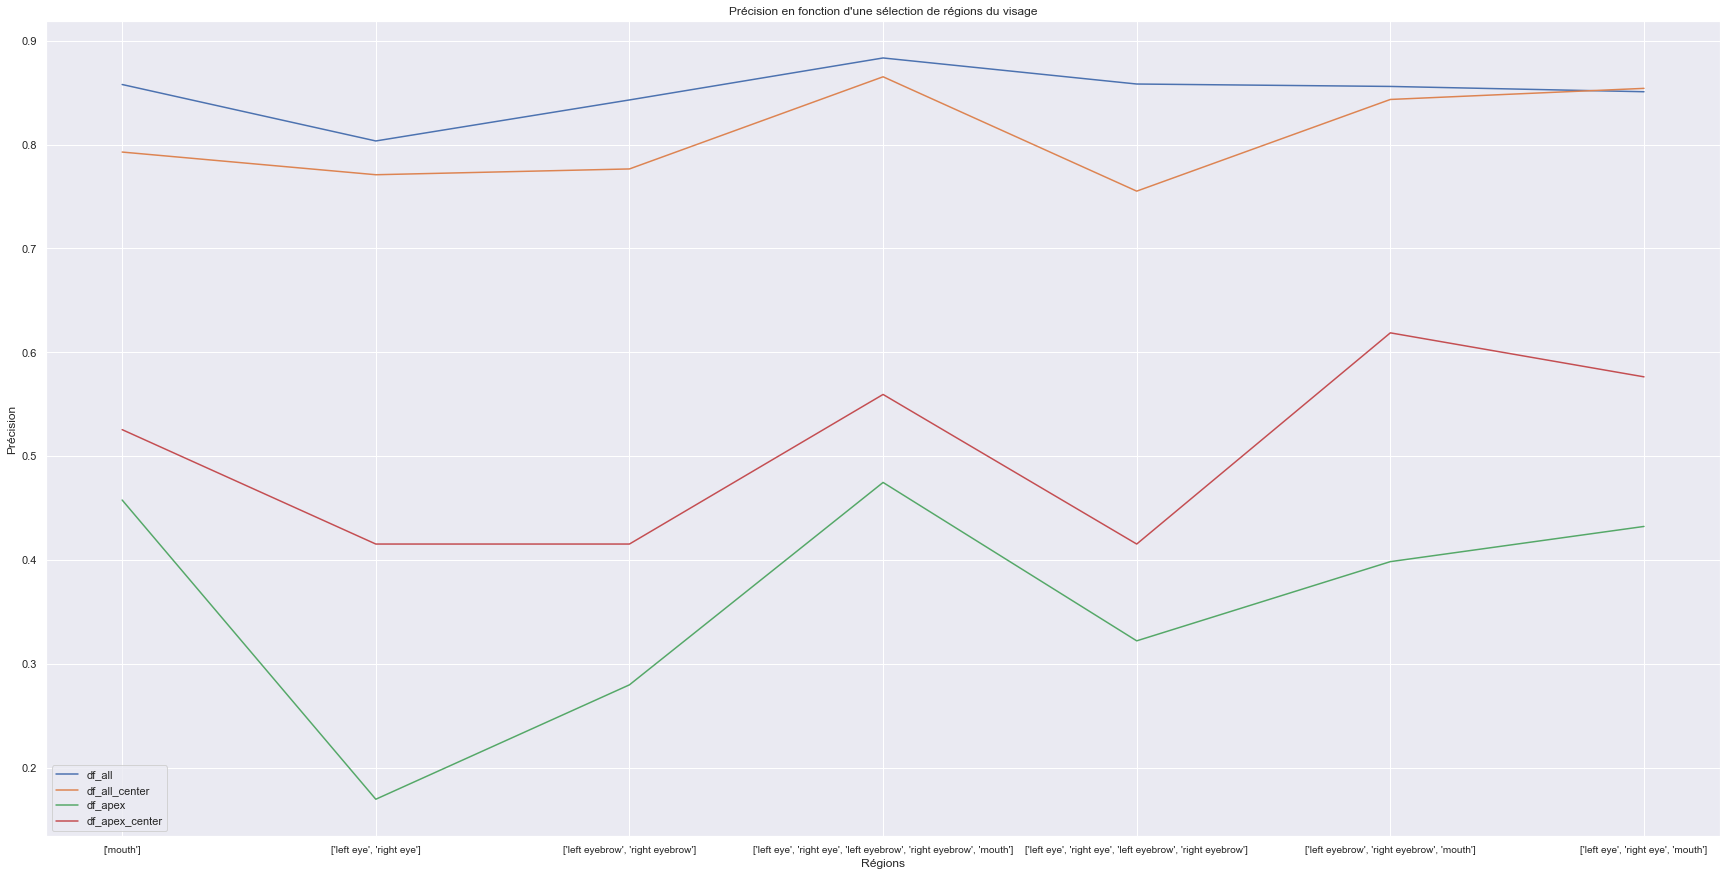

In [449]:
plt_score_region(score_regions,selected_regions,['df_all','df_all_center','df_apex','df_apex_center'])

* On peut ainsi constater à l'aide de ce graphique que les sélections de régions qui ne contienent pas la bouche sont sujets à des pertes en précision du modèle, mais également les sourcils.
* Ainsi globalement les meilleurs résultas sont obtenus par la combinaisons de la bouche et des sourcils

On peut donc tendre à penser sur le fait que les points qui apportent le plus d'expressivité par rapport à l'expression du visage sont les points de la boucheet/ou des sourcils.

* Effectuons la démarche sur les dataframes équilibrés :

In [450]:
score_regions_equi = [get_score_region(DecisionTreeClassifier(),df,selected_regions,verbose=False)
                      for df in [df_all_equi,df_all_equi_center,df_apex_equi,df_apex_equi_center]]

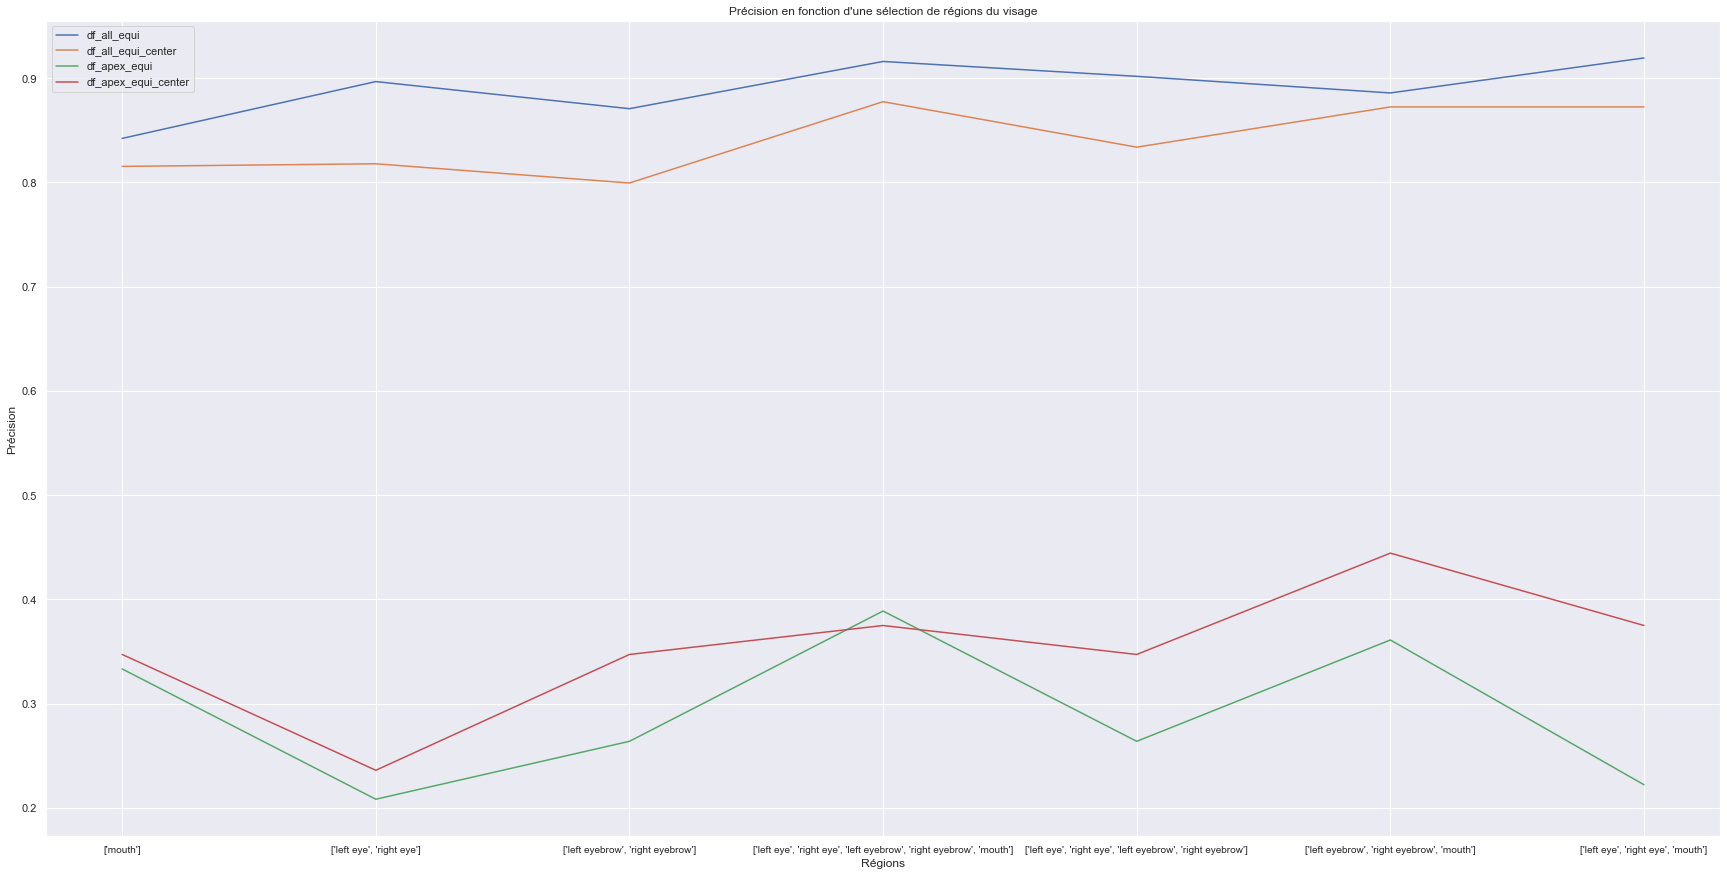

In [451]:
plt_score_region(score_regions_equi,selected_regions,['df_all_equi','df_all_equi_center','df_apex_equi','df_apex_equi_center'])

* Nous pouvons effectuer ici le même constat qu'avec les dataframes non équilibrés

* Observons maintenant avec l'ajout de bruitage dans nos données en entraînement avec sélection de régions du visage :

In [452]:
score_regions_noise = [get_score_region(DecisionTreeClassifier(),df,selected_regions,noise=(0,30,True),verbose=False)
                 for df in [df_all,df_all_center,df_apex,df_apex_center]]

Remarque : le bruit ici est le suivant : np.random.normal(0, 30)

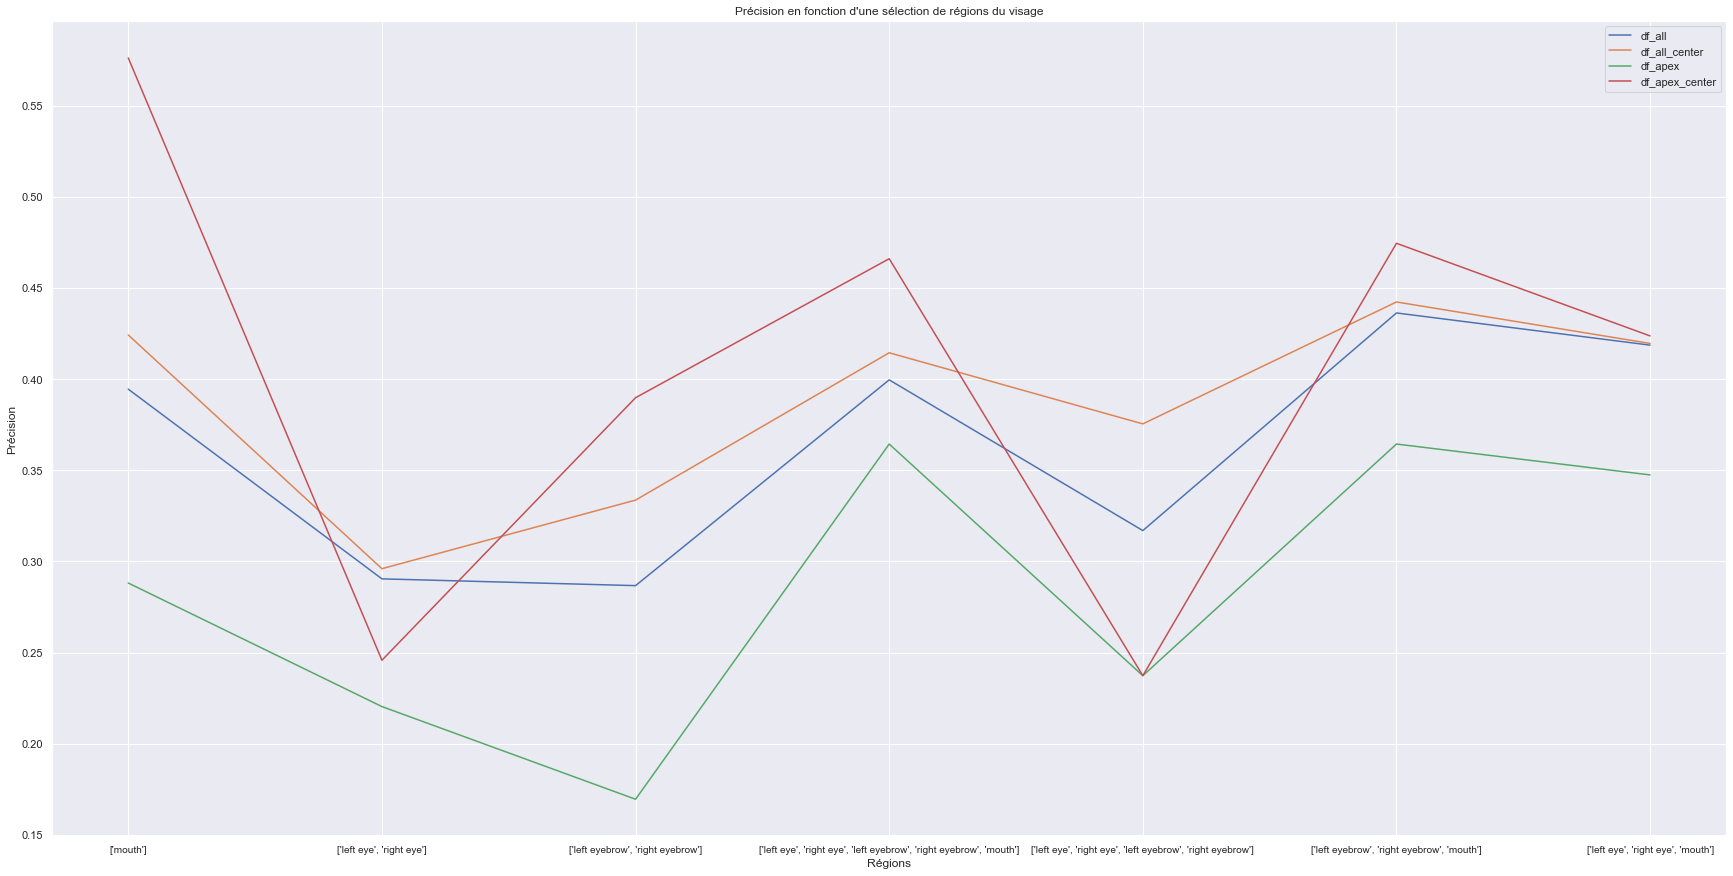

In [453]:
plt_score_region(score_regions_noise,selected_regions,['df_all','df_all_center','df_apex','df_apex_center'])

* On peut constater que l'ajout de bruitage (assez conséquent avec $add\_noise(\mu = 0, \sigma = 30)$) combiné avec des occultations de régions du visage fait chuter la précision de notre modèle presque au moins de moitié dans certains cas
* A l'aide du graphique on peut constater en comparaison du même graphique sans bruitage que dans ce cas présent avec bruitage, la présence de la bouche dans les zones considérés du visage en entraînement permet de faire moins chuter la précision si l'on compare avec les autres régions.
* L'ajout du bruit a un impact beaucoup plus important que l'occultation de régions du visage sur la capacité prédictive de notre modèle 

* Voyons avec un bruit moins important maintenant : np.random.normal(0, 15)

In [454]:
score_regions_noise_15 = [get_score_region(DecisionTreeClassifier(),df,selected_regions,noise=(0,15,True),verbose=False)
                 for df in [df_all,df_all_center,df_apex,df_apex_center]]

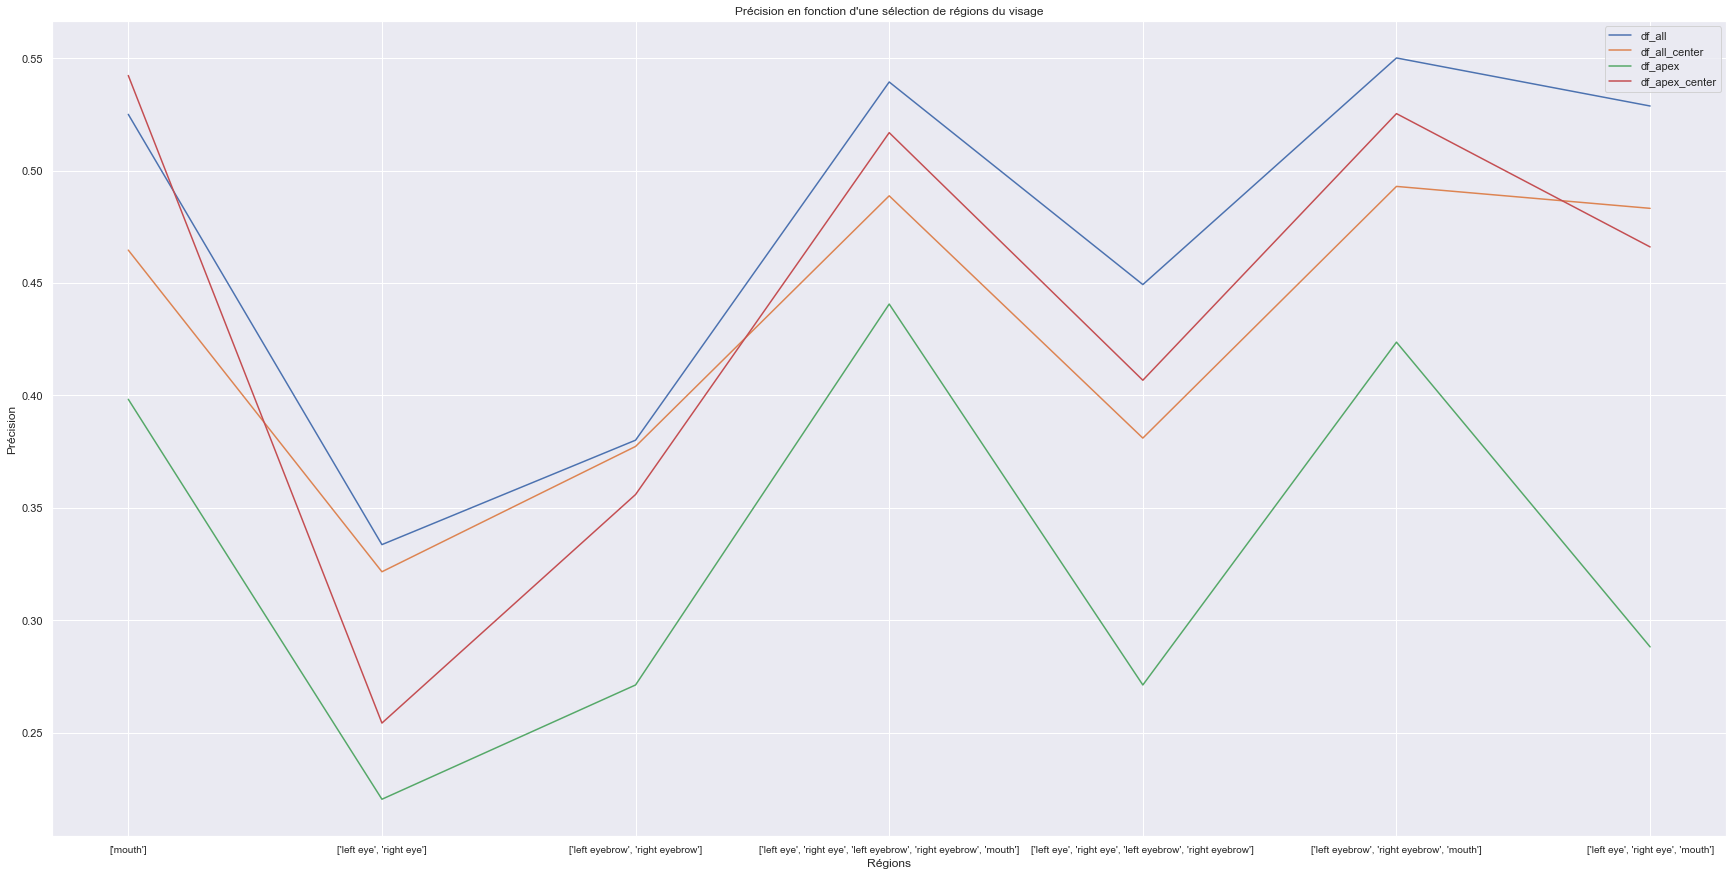

In [455]:
plt_score_region(score_regions_noise_15,selected_regions,['df_all','df_all_center','df_apex','df_apex_center'])

* On peut constater qu'avec un bruit deux fois moins important on obtient les mêmes comportements de courbes pour les mêmes régions sélectionnées
* On peut observer également que le bruit étant moins important, son impact sur la précision l'est aussi mais reste tout de même assez conséquent par rapport au précision obtenues avec un entraînement sans bruitage et avec uniquement occultations que nous avons pu observer précédemment

En conclusion de cette troisième approche : 

* Nous avons pu constater que l'occultation de zones du visage pouvait avoir des conséquences importantes sur la capacité de prédiction de notre modèle en fonction des zones retenues précisément, plus que du nombre de zones occultées comme on pourrait le penser sans observation.
* Ainsi nous avons pu dans un premier temps mettre en évidence l'importante expressivité/quantité d'information qu'apportent certaines zones du visage pour la prédiction, comme la présence ou non des points de coordonnées de la bouche ou des sourcils.

* Dans un deuxième temps nous avons en addition à ces occultations, ajouter un bruitage que nous avons réduit ensuite. Ce qui nous a permis de constater que le bruitage des coordonnées des points données en apprentissage à notre modèle influer beaucoup plus que l'occultation de zones du visage.
* Avec un bruitage suivant une loi normale (0,30) nous avons pu voir la précision descendre de moitié au minimum dans la majorité des cas, cette chute de précision est atténuer en réduisant l'intervalle que suit la loi normale.